# Differentiate weed from plant seedling using Convolutional Neural Network

@author: Amulya Badal

In this notebook we will be building a convolutional neural network to identify if a given picture is of a weed or one of the 12 species of crop seedlings of interest. 

# Dataset

The data can be found here - https://www.kaggle.com/c/plant-seedlings-classification/data .
Train folder consists of 12 image folders for 12 species of crop seedlings respectively. 

## 1. Analyze Data

In [152]:
import numpy as np
import pandas as pd
import urllib3
import cv2
import mxnet as mx
from mxnet import ndarray as nd, autograd, gluon
from mxnet.gluon import nn
import urllib
from PIL import Image
from sklearn.cross_validation import train_test_split
import zipfile
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

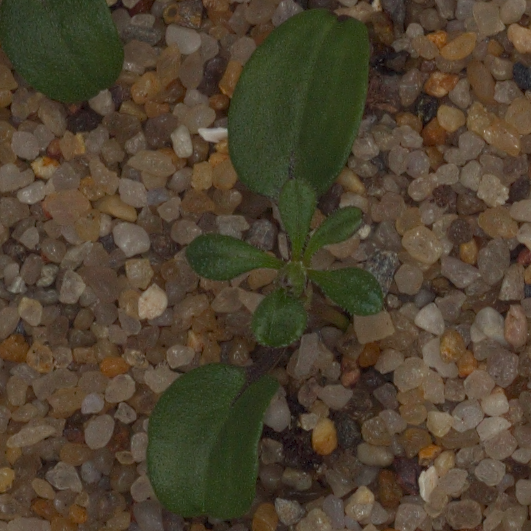

In [153]:
# Arranging data and opening an image file
data_dir = '../kaggle_plantSeedling/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
train_image_files=glob.glob(os.path.join(train_dir, '*/*.png'))
Image.open(train_image_files[0])

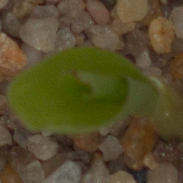

In [154]:
Image.open(train_image_files[4749])

In [165]:
len(train_image_files)

4750

These are the 12 species of interest - 

'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed','Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet'          

In [160]:
# Lets look at the shape of some of the image files
tmp = np.array(Image.open(train_image_files[0]))
tmp.shape

(531, 531, 3)

In [161]:
tmp1 = np.array(Image.open(train_image_files[4749]))
tmp1.shape

(183, 183, 3)

In [162]:
#Store species information in variables
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
           'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
           'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)

num_species

12

In [174]:
# Arrange data in the format we need and store the train data in a data frame
train = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
print(train_df.shape)


(4750, 4)


In [199]:
train_df.head() 

,filepath,file,species_id,species
0,train/Black-grass/5a1295fb4.png,5a1295fb4.png,0,Black-grass
1,train/Black-grass/d8afd58f3.png,d8afd58f3.png,0,Black-grass
2,train/Black-grass/418808d19.png,418808d19.png,0,Black-grass
3,train/Black-grass/eac39cfa8.png,eac39cfa8.png,0,Black-grass
4,train/Black-grass/39e9bf4c7.png,39e9bf4c7.png,0,Black-grass


In [179]:
img_paths_and_label = train_df[['filepath', 'species_id']].values

In [180]:
img_paths_and_label[:10]

array([['train/Black-grass/5a1295fb4.png', 0],
       ['train/Black-grass/d8afd58f3.png', 0],
       ['train/Black-grass/418808d19.png', 0],
       ['train/Black-grass/eac39cfa8.png', 0],
       ['train/Black-grass/39e9bf4c7.png', 0],
       ['train/Black-grass/2aa60045d.png', 0],
       ['train/Black-grass/5e21fa6f1.png', 0],
       ['train/Black-grass/4cd2a07dd.png', 0],
       ['train/Black-grass/d3e69adad.png', 0],
       ['train/Black-grass/dde665ea5.png', 0]], dtype=object)

In [181]:
# The images are of different sizes. So lets resize all images to 128, 128
# MXNet expects input dimensions as (batch_size, channel, height, width), so we need to rearrange some axes.
X = []
Y = []

NEW_SZ = 128, 128

for image_file, label in img_paths_and_label:
    img = Image.open(image_file).convert('RGB').resize(NEW_SZ)
    img = np.array(img)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    
    X.append(img)
    Y.append(label)
    
npX = np.stack(X)
npY = np.array(Y)

In [185]:
#Lets look at the shape after swapping axes
npX.shape, npY.shape ### batch_size, channel, height, width

((4750, 3, 128, 128), (4750,))

In [187]:
# Save the array for future use
import pickle
pickle.dump(npX, open("dataX.npy", "wb"))
pickle.dump(npY, open("dataY.npy", "wb"))

In [189]:
#Lest split the data into train and validation
train_X, validation_X, train_Y, validation_Y = train_test_split(npX, npY, test_size=0.2, random_state=1001)

## 2. Build the Model

Simple 3 Layer CNN - more info available here in the [Gluon tutorial](https://gluon.mxnet.io/chapter04_convolutional-neural-networks/cnn-scratch.html)

In [190]:
num_classes = 12
        
net = gluon.nn.Sequential()
with net.name_scope():
    
    # CNN Layer
    net.add(gluon.nn.Conv2D(channels=16, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=16, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=32, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=32, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))

    # MLP Layer
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dense(32, activation="relu"))
    net.add(gluon.nn.Dense(num_classes))

In [191]:
net

Sequential(
  (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1))
  (5): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (6): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1))
  (7): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (8): Flatten
  (9): Dense(None -> 64, Activation(relu))
  (10): Dense(None -> 32, Activation(relu))
  (11): Dense(None -> 12, linear)
)

## 3. Train

In [192]:
batch_size = 64
train_iter = mx.io.NDArrayIter(data=train_X, label=train_Y, batch_size=batch_size, shuffle=True)
validation_iter = mx.io.NDArrayIter(data=validation_X, label=validation_Y, batch_size=batch_size)

In [193]:
ctx = mx.cpu(0)

net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 1E-3})

In [194]:
def evaluate_accuracy(net, data_iterator):
    acc = mx.metric.Accuracy()
    while True:
        try:
            batch = next(data_iterator)
        except StopIteration:
            train_iter.reset()
            break        
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [195]:
smoothing_constant = .01
epochs = 25
ctx = ctx
loss_vals = []
train_acc = []
val_acc = []
train_iter.reset()
validation_iter.reset()

for e in range(epochs):
    i = 0
    while True:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        #print data.shape, label.shape
        with autograd.record(train_mode=True):
            output = net(data)
            loss = loss_function(output, label)
        loss.backward()
        optimizer.step(data.shape[0])

        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        loss_vals.append(moving_loss)
        i +=1
        if i % 10 == 0: #every 10 batch
            print moving_loss
        
    train_accuracy = evaluate_accuracy(net, train_iter)
    test_accuracy = evaluate_accuracy(net, validation_iter)
    
    # reset iterators
    train_iter.reset()
    validation_iter.reset()
    
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))
    train_acc.append(train_accuracy)
    val_acc.append(test_accuracy)

4.83529832079
4.60797821302
4.39810213818
4.20942962448
4.03759132191
3.87946560174
Epoch 0. Loss: 3.87946560174, Train_acc 0.14609375, Test_acc 0.121875
3.73617563046
3.60477611894
3.48231343653
3.37284599458
3.26924199273
3.17552368264
Epoch 1. Loss: 3.17552368264, Train_acc 0.166145833333, Test_acc 0.159375
3.09508369615
3.01080754017
2.92388928064
2.83961557485
2.74889525419
2.65628028951
Epoch 2. Loss: 2.65628028951, Train_acc 0.432552083333, Test_acc 0.414583333333
2.56915078148
2.48134184849
2.38579633278
2.2988260948
2.19837418224
2.10300186761
Epoch 3. Loss: 2.10300186761, Train_acc 0.600260416667, Test_acc 0.561458333333
2.01999409181
1.93818572429
1.85685908384
1.79149571559
1.71951683122
1.64843965626
Epoch 4. Loss: 1.64843965626, Train_acc 0.668489583333, Test_acc 0.626041666667
1.58848506696
1.53444512547
1.48489723577
1.44013253027
1.38131678377
1.32296598974
Epoch 5. Loss: 1.32296598974, Train_acc 0.726302083333, Test_acc 0.665625
1.2780274638
1.23903241509
1.2098972375

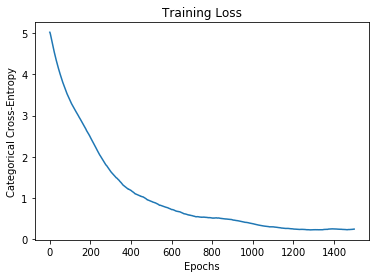

In [196]:
plt.figure()
plt.title('Training Loss')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epochs')
plt.plot(loss_vals)

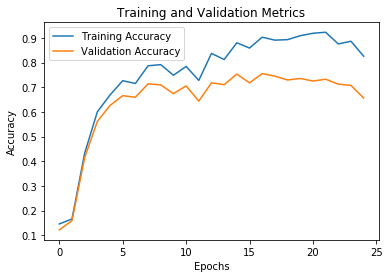

In [198]:
plt.figure()
plt.title('Training and Validation Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Training Accuracy', 'Validation Accuracy'])

The accuracy is hovering around 70% which is not great. 

# Things to try next

1. More CNN filters in each layer
2. Image augementation to create a larger training set
3. Hyperparameter optimization